In [1]:
import os
import sys
import torch
import random
import argparse
import numpy as np
import scipy
from matplotlib import pyplot
import numpy

sys.path.append('../../timeseries/')
sys.path.append('../../timeseries/experiments_scripts/')
sys.path.append('../../src/')

import factors
import state_models
import observation_models
from ssm_em import StateSpaceEM
from nonlinear_ssm import NonLinearStateSpace_EM

from scipy.stats import norm
from scipy.stats import zscore
from ssm_em import StateSpaceEM, load_model
from sklearn.covariance import EmpiricalCovariance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

from exp_utils import *
import ssm
import statsmodels.api as sm

'''
sys.path.append('../../timeseries/kalman-jax-master')
from jax.experimental import optimizers
#from sde_gp import SDEGP
import approximate_inference as approx_inf
import priors
import likelihoods
from utils import softplus_list, plot
'''


class PredictiveDensity:
    def __init__(self, mu, sigma):
        if mu.ndim == 1:
            self.mu = np.array([mu]).T
        else:
            self.mu = np.array(mu)
        if sigma.ndim == 1:
            self.Sigma = np.array([sigma]).T
        else:    
            self.Sigma = np.array(sigma)
            
def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def train_linear_SSM(x_tr, dz, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm = state_models.LinearStateModel(dz)
    om = observation_models.LinearObservationModel(dx, dz, noise_x=1.)
    
    if init_w_pca == 1:
        om.pca_init(x_tr, smooth_window=smooth_window)
        
    ssm_em_lin = StateSpaceEM(x_tr, observation_model=om, state_model=sm)
    ssm_em_lin.run()
    
    return ssm_em_lin


def train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=False, smooth_window=20):

    dx = x_tr.shape[1]
    sm_hs = state_models.LinearStateModel(dz)
    om_hs = observation_models.HCCovObservationModel(dx, dz, du)
    if init_w_pca == 1:
        om_hs.pca_init(x_tr, smooth_window=20)
    hs_model = StateSpaceEM(x_tr, observation_model=om_hs, state_model=sm_hs, conv_crit=1e-4)
    hs_model.run()
    
    return hs_model

def train_nonlinear_SSM(x_tr, **kwargs):
    '''
    to be updated; currently doesn't run
    LSEMStateModel -> sm_hs = state_models.LSEMStateModel(args.dz,args.dk# + param for basis func)
    '''
    nonlin_model = NonLinearStateSpace_EM(x_tr,args.dz, args.dk)
    nonlin_model.run()
    
    return nonlin_model

class HMM_class:
    
    def __init__(self, x_tr, K, obs_model='gaussian'):
        self.x_tr = x_tr
        self.D = x_tr.shape[1]
        self.K = K
        self.obs_model = obs_model
        self.model = self._train()
        
    def _train(self):
        model = ssm.HMM(self.K, self.D, observations=self.obs_model)
        model.fit(self.x_tr, method="em")
        return model

    def compute_predictive_log_likelihood(self, x_te, ignore_init_samples=0):
        mask = np.logical_not(np.isnan(x_te))
        x_te_not_nan = np.zeros(x_te.shape)
        x_te_not_nan[mask] = x_te[mask]
        states = self.model.filter(x_te_not_nan, mask=mask)
        llk_states = numpy.empty(states.shape)
        for k in range(self.K):
            mu, Sigma  = self.model.observations.mus[k], self.model.observations.Sigmas[k]
            llk_states[:,k] = scipy.stats.multivariate_normal(mu, Sigma).logpdf(x_te)
        llk =  numpy.sum(scipy.special.logsumexp(llk_states[ignore_init_samples:], axis=1, b=states[ignore_init_samples:])[:])
        return llk
    
    def compute_predictive_density(self, x_te):
        mask = np.logical_not(np.isnan(x_te))
        x_te_not_nan = np.zeros(x_te.shape)
        x_te_not_nan[mask] = x_te[mask]
        states = self.model.filter(x_te_not_nan, mask=mask)
        if self.obs_model == 'gaussian' or  self.obs_model == 'studentst':
            mean_te = np.dot(states, self.model.observations.mus)
        elif self.obs_model == 'ar':
            mean_te = np.sum(states[:,:,None] * (np.sum(self.model.observations.As[None] * x_te[:,None, None], axis=3) + self.model.observations.bs), axis=1)
        std_te = np.dot(states, np.sqrt(self.model.observations.Sigmas.diagonal(axis1=1, axis2=2)))
        print(mean_te.shape, std_te.shape)
        return PredictiveDensity(mean_te, std_te ** 2)

def train_HMM(x_tr, num_states, **kwargs):
    return HMM_class(x_tr, num_states)


class ARIMAX:
    
    def __init__(self, x_tr, p, q):
        self.x_tr = x_tr
        self.p = p
        self.q = q
        self._train()
        
    def _train(self):
        if x_tr.shape[1] == 1:
            self.mod = sm.tsa.statespace.SARIMAX(x_tr, trend='c', order=(self.p,0,self.q))
            self.fit_res = self.mod.fit(disp=False)
        else:
            self.mod = sm.tsa.VARMAX(x_tr, trend='c', order=(self.p,self.q))
            self.fit_res = self.mod.fit(disp=False, max_iter=1000)
            
    def compute_predictive_density(self, x_te):
        mod_te = self.mod.clone(x_te)
        res = mod_te.filter(self.fit_res.params)
        predict = res.get_prediction()
        predict_ci = predict.conf_int(alpha=1.-.68)
        mu = predict.predicted_mean
        if x_te.shape[1] == 1:
            std = predict.predicted_mean - predict_ci[:,0]
        else:
            std = predict.predicted_mean - predict_ci[:,:x_te.shape[1]]
        return PredictiveDensity(mu, std ** 2)
            
    def compute_predictive_log_likelihood(self, x_te, ignore_init_samples=0):  
        mod_te = self.mod.clone(x_te[ignore_init_samples:])
        return mod_te.loglike(self.fit_res.params)
    
def train_arimax(x_tr, p, q):
    
    arimax_model = ARIMAX(x_tr, p, q)
    return arimax_model

In [2]:
seed = 0
reset_seeds(seed)
K = 6
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1(train_ratio=.5)
hmm = train_HMM(x_tr, K)

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
hmm.compute_predictive_log_likelihood(x_va, ignore_init_samples=10)

-265.20875071930146

In [3]:
seed = 0
reset_seeds(seed)
dz = 3
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1(train_ratio=.5)
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=True)

Iteration 2 - llk=-2485.9
Iteration 4 - llk=-1633.0
Iteration 6 - llk=-1227.0
Iteration 8 - llk=-1017.7
Iteration 10 - llk=-937.7
Iteration 12 - llk=-883.5
Iteration 14 - llk=-828.5
Iteration 16 - llk=-778.8
Iteration 18 - llk=-741.5
Iteration 20 - llk=-716.8
Iteration 22 - llk=-700.7
Iteration 24 - llk=-689.7
Iteration 26 - llk=-681.5
Iteration 28 - llk=-675.2
Iteration 30 - llk=-669.9
Iteration 32 - llk=-665.2
Iteration 34 - llk=-661.0
Iteration 36 - llk=-657.2
Iteration 38 - llk=-653.6
Iteration 40 - llk=-650.2
Iteration 42 - llk=-647.0
Iteration 44 - llk=-644.0
Iteration 46 - llk=-641.2
Iteration 48 - llk=-638.5
Iteration 50 - llk=-636.0
Iteration 52 - llk=-633.5
Iteration 54 - llk=-631.1
Iteration 56 - llk=-628.8
Iteration 58 - llk=-626.6
Iteration 60 - llk=-624.4
Iteration 62 - llk=-622.3
Iteration 64 - llk=-620.3
Iteration 66 - llk=-618.4
Iteration 68 - llk=-616.6
Iteration 70 - llk=-614.9
Iteration 72 - llk=-613.3
Iteration 74 - llk=-611.9
Iteration 76 - llk=-610.5
Iteration 78

In [19]:
ssm_em_lin.compute_predictive_log_likelihood(x_va, ignore_init_samples=10)

-146.13954016928068

In [4]:
seed = 0
reset_seeds(seed)
dz, du = 3, 1
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1(train_ratio=.5)
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True)

Iteration 2 - llk=-1198.5
Iteration 4 - llk=-683.0
Iteration 6 - llk=-543.5
Iteration 8 - llk=-465.6
Iteration 10 - llk=-427.2
Iteration 12 - llk=-409.2
Iteration 14 - llk=-402.6
Iteration 16 - llk=-399.5
Iteration 18 - llk=-398.6
Iteration 20 - llk=-398.3
Iteration 22 - llk=-398.1
EM did converge.


In [8]:
x_te_nan = numpy.copy(x_te)
x_te_nan[:,0] = numpy.nan

In [9]:
hmm_pred_density = hmm.compute_predictive_density(x_te_nan)
hsk_pred_density = ssm_em_hsk.compute_predictive_density(x_te_nan)
lin_pred_density = ssm_em_lin.compute_predictive_density(x_te_nan)

(913, 4) (913, 4)


In [10]:
softp = lambda x: numpy.logaddexp(0,x)
x_te_rescaled = softp(s_tr_x.inverse_transform(x_te))
hmm_lb, hmm_ub = softp(s_tr_x.inverse_transform(hmm_pred_density.mu - 1.68 * numpy.sqrt(hmm_pred_density.Sigma))[:,0]), softp(s_tr_x.inverse_transform(hmm_pred_density.mu + 1.68 * numpy.sqrt(hmm_pred_density.Sigma))[:,0])
lin_lb, lin_ub = softp(s_tr_x.inverse_transform(lin_pred_density.mu - 1.68 * numpy.sqrt(lin_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,0]), softp(s_tr_x.inverse_transform(lin_pred_density.mu + 1.68 * numpy.sqrt(lin_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,0])
hsk_lb, hsk_ub = softp(s_tr_x.inverse_transform(hsk_pred_density.mu - 1.68 * numpy.sqrt(hsk_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,0]), softp(s_tr_x.inverse_transform(hsk_pred_density.mu + 1.68 * numpy.sqrt(hsk_pred_density.Sigma.diagonal(axis1=1,axis2=2)))[:,0])

In [15]:
from timeseries_data import load_opsd_data
raw_data = load_opsd_data().iloc[-x_te.shape[0]:]
raw_data

,DE_solar_generation_actual,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal
utc_timestamp,,,,
2017-07-02,4431.583333,15.734708,65.438106,152.150181
2017-07-03,8191.708333,16.783042,231.062259,81.040345
2017-07-04,8072.000000,18.089458,244.409912,74.954288
2017-07-05,8393.333333,19.810333,199.826599,95.795043
2017-07-06,9055.916667,22.014000,251.510509,70.882495
...,...,...,...,...
2019-12-27,873.250000,1.327167,7.417462,25.590579
2019-12-28,1509.958333,-1.441167,22.312099,21.662639
2019-12-29,2287.916667,-1.314500,9.583297,26.068895


In [16]:
date = raw_data.index
tick_idx = numpy.where(date.is_month_start)[0]

In [17]:
tick_labels = []
for i, idx in enumerate(tick_idx):
    label = date[idx].month_name()[:3] + str(date[idx].year)[-2:]
    tick_labels.append(label)
tick_labels

['Aug17',
 'Sep17',
 'Oct17',
 'Nov17',
 'Dec17',
 'Jan18',
 'Feb18',
 'Mar18',
 'Apr18',
 'May18',
 'Jun18',
 'Jul18',
 'Aug18',
 'Sep18',
 'Oct18',
 'Nov18',
 'Dec18',
 'Jan19',
 'Feb19',
 'Mar19',
 'Apr19',
 'May19',
 'Jun19',
 'Jul19',
 'Aug19',
 'Sep19',
 'Oct19',
 'Nov19',
 'Dec19']

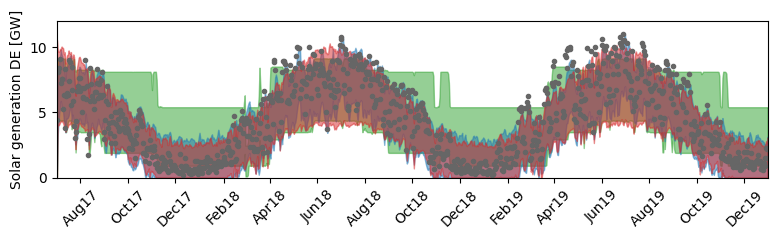

In [24]:
pyplot.rcdefaults()
pyplot.rc('font', size = 14)
fig = pyplot.figure(figsize=(8,2.5))
gs = fig.add_gridspec(1, 5)
#ax1 = fig.add_subplot(gs[:3])
ax1 = fig.add_subplot(111)
ax1.fill_between(range(hmm_lb.shape[0]), hmm_lb, hmm_ub, color='C2', alpha=.5)
ax1.fill_between(range(lin_lb.shape[0]), lin_lb, lin_ub, color='C0', alpha=.5)
ax1.fill_between(range(hsk_lb.shape[0]), hsk_lb, hsk_ub, color='C3', alpha=.5)
ax1.plot(range(hmm_lb.shape[0]), raw_data['DE_solar_generation_actual'], color=[.4,.4,.4], marker='.', lw=0)
ax1.set_xticks(tick_idx[::2])
ax1.set_xticklabels(tick_labels[::2] , rotation=45, fontsize=10)
ax1.set_xlim([0,x_te.shape[0]-1])
ax1.set_ylim([0,12000])
ax1.set_yticks([0,5000,10000])
ax1.set_yticklabels([0,5,10], fontsize=10)
ax1.set_ylabel('Solar generation DE [GW]', fontsize=10)
"""
ax2 = fig.add_subplot(gs[3])
dx = 0
hsk_cdf = numpy.sort(scipy.stats.norm.cdf((x_te[10:,dx] - hsk_pred_density.mu[10:,dx]) / numpy.sqrt(hsk_pred_density.Sigma[10:,dx,dx])))
lin_cdf = numpy.sort(scipy.stats.norm.cdf((x_te[10:,dx] - lin_pred_density.mu[10:,dx]) / numpy.sqrt(lin_pred_density.Sigma[10:,dx,dx])))
hmm_cdf = numpy.sort(scipy.stats.norm.cdf((x_te[10:,dx] - hmm_pred_density.mu[10:,dx]) / numpy.sqrt(hmm_pred_density.Sigma[10:,dx])))
ax2.plot(numpy.linspace(0,1,x_te.shape[0]-10), lin_cdf, color='C0', alpha=.7, lw=2)
ax2.plot(numpy.linspace(0,1,x_te.shape[0]-10), hmm_cdf, color='C2', alpha=.7, lw=2)
ax2.plot(numpy.linspace(0,1,x_te.shape[0]-10), hsk_cdf, color='C3', alpha=1)
ax2.plot([0,1], [0,1], 'k--', lw=1., alpha=.5)

ax3 = fig.add_subplot(gs[4])
ax3.plot(numpy.linspace(0,1,x_te.shape[0]-10), 100 * (lin_cdf - numpy.linspace(0,1,x_te.shape[0]-10)), color='C0', alpha=.7, lw=2)
ax3.plot(numpy.linspace(0,1,x_te.shape[0]-10), 100 * (hmm_cdf - numpy.linspace(0,1,x_te.shape[0]-10)), color='C2', alpha=.7, lw=2)
ax3.plot(numpy.linspace(0,1,x_te.shape[0]-10), 100 * (hsk_cdf - numpy.linspace(0,1,x_te.shape[0]-10)), color='C3', alpha=.7, lw=2)
ax3.plot([0,1], [0,0], 'k--', lw=1., alpha=.5)
"""
pyplot.tight_layout()
fig.savefig('../../figs/aistats22/energy_missing.pdf')
fig.savefig('../../figs/aistats22/energy_missing.png', dpi=600)

In [27]:
seed = 0
reset_seeds(seed)
p, q = 1, 1
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1(train_ratio=.75)
arimax = train_arimax(x_tr, p, q)
arimax.compute_predictive_log_likelihood(x_te)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


-327.1764361909373

In [3]:
smooth_window = 20
dz, du = observation_models.recommend_dims(x_tr, smooth_window=20)

In [4]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()
ssm_em_lin = train_linear_SSM(x_tr, dz, init_w_pca=True, smooth_window=smooth_window)
ssm_em_lin.save(model_name='ssm_em_lin_energy', path='../../data/models/')

Iteration 2 - llk=-2821.0
Iteration 4 - llk=-1851.6
Iteration 6 - llk=-1378.8
Iteration 8 - llk=-1131.1
Iteration 10 - llk=-1033.5
Iteration 12 - llk=-964.3
Iteration 14 - llk=-900.1
Iteration 16 - llk=-850.9
Iteration 18 - llk=-819.4
Iteration 20 - llk=-800.0
Iteration 22 - llk=-787.6
Iteration 24 - llk=-778.9
Iteration 26 - llk=-772.4
Iteration 28 - llk=-767.3
Iteration 30 - llk=-762.9
Iteration 32 - llk=-759.1
Iteration 34 - llk=-755.5
Iteration 36 - llk=-752.1
Iteration 38 - llk=-748.7
Iteration 40 - llk=-745.1
Iteration 42 - llk=-741.3
Iteration 44 - llk=-737.3
Iteration 46 - llk=-733.0
Iteration 48 - llk=-728.5
Iteration 50 - llk=-723.8
Iteration 52 - llk=-719.1
Iteration 54 - llk=-714.7
Iteration 56 - llk=-710.6
Iteration 58 - llk=-707.1
Iteration 60 - llk=-704.1
Iteration 62 - llk=-701.5
Iteration 64 - llk=-699.4
Iteration 66 - llk=-697.7
Iteration 68 - llk=-696.2
EM did converge.


In [22]:
ssm_em_lin.compute_predictive_log_likelihood(x_te)

-920.9986477284034

In [23]:
pred_density = ssm_em_lin.compute_predictive_density(x_te)
mu, Sigma = pred_density.mu, pred_density.Sigma
llk = 0
for i in range(x_te.shape[0]):
    llk += scipy.stats.multivariate_normal.logpdf(x_te[i], mu[i], Sigma[i])
llk

-920.9986477284358

In [19]:
numpy.prod(x_te.shape)

3652

In [5]:
seed = 0
reset_seeds(seed)
x_tr, x_va, x_te, x_te_na, s_tr_x = load_energy_e1()
ssm_em_hsk = train_linear_hsk_SSM(x_tr, dz, du, init_w_pca=True, smooth_window=smooth_window)
ssm_em_hsk.save(model_name='ssm_em_hsk_energy', path='../../data/models/')

Iteration 2 - llk=-1216.6
Iteration 4 - llk=-809.3
Iteration 6 - llk=-721.8
Iteration 8 - llk=-649.9
Iteration 10 - llk=-618.8
Iteration 12 - llk=-606.2
Iteration 14 - llk=-593.2
Iteration 16 - llk=-580.6
Iteration 18 - llk=-565.9
Iteration 20 - llk=-549.8
Iteration 22 - llk=-538.6
Iteration 24 - llk=-527.4
Iteration 26 - llk=-518.1
Iteration 28 - llk=-508.0
Iteration 30 - llk=-498.8
Iteration 32 - llk=-490.1
Iteration 34 - llk=-484.4
EM did converge.


In [7]:
ssm_em_hsk = load_model(model_name='ssm_em_hsk_energy', path='../../data/models/')
ssm_em_lin = load_model(model_name='ssm_em_lin_energy', path='../../data/models/')

In [8]:
ssm_em_lin.compute_predictive_log_likelihood(x_te)

-1589.4755942218233

In [16]:
ssm_em_hsk.compute_predictive_log_likelihood(x_te)

-1157.9546717677083

In [10]:
pred_hsk = ssm_em_hsk.compute_predictive_density(x_te)
pred_lin = ssm_em_lin.compute_predictive_density(x_te)

Text(0.5, 0, 'Time steps')

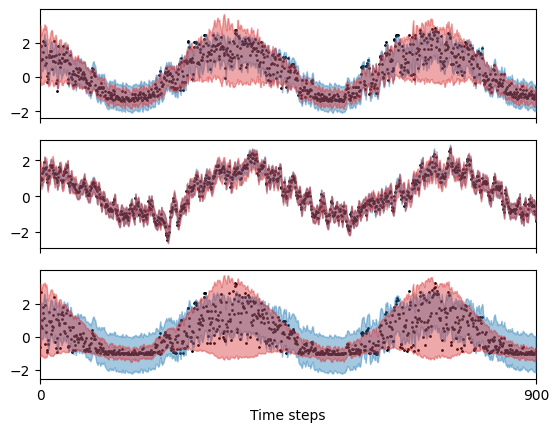

In [15]:
pyplot.rcdefaults()
mu_hsk, std_hsk = pred_hsk.mu, numpy.sqrt(pred_hsk.Sigma.diagonal(axis1=1, axis2=2))
mu_lin, std_lin = pred_lin.mu, numpy.sqrt(pred_lin.Sigma.diagonal(axis1=1, axis2=2))

fig = pyplot.figure()
for idx in range(3):
    ax = fig.add_subplot(3,1,idx+1)
    pyplot.plot(x_te[10:1010,idx], 'k.', ms=2)
    pyplot.fill_between(range(900), mu_hsk[10:910,idx] - 1.68 * std_hsk[10:910,idx], mu_hsk[10:910,idx] + 1.68 * std_hsk[10:910,idx], color='C3', alpha=.4, zorder=9, label='heterosk.')
    pyplot.fill_between(range(900), mu_lin[10:910,idx] - 1.68 * std_lin[10:910,idx], mu_lin[10:910,idx] + 1.68 * std_lin[10:910,idx], color='C0', alpha=.4, zorder=7, label='homosk.')
    pyplot.xlim([0,900])
    pyplot.xticks([0,900], labels=[])
    pyplot.yticks([-2,0,2])
    #pyplot.ylim([-3,3])
pyplot.xticks([0,900], labels=[0,900])
#pyplot.legend(frameon=False)
idx = 2
pyplot.xlabel('Time steps')
#pyplot.plot(mu_hsk[:1000,idx], color='C0')
#pyplot.plot(mu_hsk[:1000,idx], color='C3')